In [1]:
%load_ext autoreload
%autoreload 2


import sys

# implementation of reverse_shuffle
sys.path.insert(0, "/Users/user/git/eli5/")
import eli5

sys.path.insert(0, "/Users/user/git/gplearn/")
import gplearn

sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse_score
from plots import *
import sci.features as scif
import sci.learn as scil
import sci.plots as scip

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to
pd.options.display.max_rows = 999

import numpy as np

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import gplearn

random_state =1

modified eli5
modified PermutationImportance sklearn
GPLEARN MOD


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


## Load Data

In [2]:
data = scil.load_data("processed_min", random_state=random_state)

print("train:", data.X_train.shape)
print("test:", data.X_test.shape)

(891, 8) (891,)
train: (712, 8)
test: (179, 8)


In [5]:
# path = 'processed_min'
# !mkdir -p $path
# X_train.to_msgpack(f'{path}/X.msgpack')
# y.to_msgpack(f'{path}/y.msgpack')
# X_score.to_msgpack(f'{path}/X_score.msgpack')

# # from sklearn.externals import joblib
# # joblib.dump(y_tr, f'{path}/y_tr.joblib')


In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(data.X_train)

data_gp = scil.Data(pd.DataFrame(sc.transform(data.X), index=data.X.index, columns=data.X.columns), data.y)
data_gp.X_score = pd.DataFrame(sc.transform(data.X_score), index=data.X_score.index, columns=data.X_score.columns)

data_gp = data

In [138]:
def sigmoid(x):
    sigm = 1. / (1. + np.exp(-x))
    return sigm

def Outputs(data):
    return 1.-(1./(1.+np.exp(-data)))

Outputs = sigmoid

from sklearn.metrics import *
def roc_auc_metric(y_true, y_score, sample_weight):
    try:
        y_score = Outputs(y_score)
        return roc_auc_score(y_true, y_score, sample_weight=sample_weight)
    except:
        return 0
                        
from gplearn.fitness import make_fitness
roc_auc_fitness = make_fitness(roc_auc_metric, greater_is_better=True)

In [139]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min',
                'sin', 'cos', 'tan']


In [140]:
from gplearn.genetic import SymbolicRegressor

gp2 = SymbolicRegressor(generations=20, 
                         population_size=500,
                         function_set=function_set,
#                          metric='spearman',
                         tournament_size=5,
                       stopping_criteria=1.0,
                       metric=roc_auc_fitness, 
                       const_range=(-5, 5), 
                         parsimony_coefficient=0.0005,
#                          parsimony_coefficient=0.0005,
#                          parsimony_coefficient='auto', #0.0005,
                         max_samples=0.9, 
                        feature_names=data.X.columns,
#                         feature_names = data_gp.X.columns,
                         verbose=1,
                         random_state=1, 
                       n_jobs=3,
                       warm_start=True)

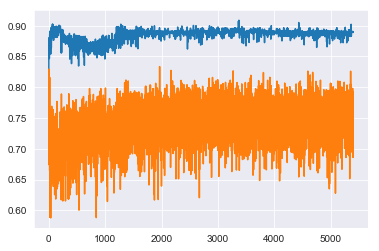

parsimony_coefficient: 5e-05
sub(sub(inv(add(min(Embarked, Pclass), add(add(div(div(Sex, add(Pclass, sub(sub(div(add(add(div(div(Sex, div(sin(Cabin), Fare)), Age), div(Embarked, Fare)), inv(Age)), Fare), Sex), Sex))), Fare), Pclass), inv(add(sub(sub(div(add(add(inv(Age), div(Sex, add(div(div(Sex, div(sin(Cabin), Fare)), Fare), add(inv(Age), Pclass)))), div(Sex, Fare)), Fare), Sex), Sex), Embarked))))), div(mul(sub(div(Sex, add(div(div(Sex, Fare), Fare), Sex)), sub(sub(sub(sub(div(mul(sub(div(Sex, add(div(div(Sex, div(inv(Age), add(div(inv(Age), div(div(div(Sex, div(inv(add(div(sin(Cabin), Fare), Embarked)), Fare)), inv(Age)), Fare)), div(div(div(Sex, Fare), Fare), Fare)))), Fare), Sex)), sub(sub(sub(sub(div(Sex, add(div(Sex, Fare), add(inv(Age), Pclass))), Sex), inv(Age)), Cabin), add(Embarked, Cabin))), sin(Cabin)), Fare), Sex), inv(Age)), Cabin), add(Embarked, Cabin))), sin(Cabin)), Fare)), Sex)
    |   Population Average    |             Best Individual              |
---- ---------

KeyboardInterrupt: 

In [223]:
from IPython.display import clear_output

# gp2.population_size=100
gp2.parsimony_coefficient = 0.00005
# gp2.tournament_size=50
# gp2.p_crossover = 0.5
# gp2.p_subtree_mutation = 0.01
# gp2.p_point_mutation = 0.4
# gp2.p_point_replace = 0.05
gp2.n_jobs = 2
for i in range(10000):
#     gp2.parsimony_coefficient = 1/(gp2.generations*1000)
    gp2.generations += 5
    gp2.fit(data_gp.X_train, data_gp.y_train)
    
    y_preds = [p.execute(data_gp.X_test.values) for p in gp2.run_details_['best_program']]
    y_preds = [Outputs(y_pred) for y_pred in y_preds]
    scores = [roc_auc_score(data_gp.y_test, y_pred) for y_pred in y_preds]

    clear_output()
    plt.plot(scores, label="X_test")
    plt.plot(gp2.run_details_['best_oob_fitness'], label="oob")
#     plt.legend()
    plt.show()
    print("parsimony_coefficient:", gp2.parsimony_coefficient)
    print(gp2._program)

In [151]:
from gplearn.genetic import SymbolicRegressor

gp = SymbolicRegressor(generations=300, 
                         population_size=1000,
                         function_set=function_set,
#                          metric='spearman',
                         tournament_size=10,
                       stopping_criteria=1.0,
                       metric=roc_auc_fitness, 
                       const_range=(-100, 100), 
                         parsimony_coefficient=0.00001,
#                          parsimony_coefficient=0.0005,
#                          parsimony_coefficient='auto', #0.0005,
                         max_samples=0.9, 
                        feature_names = data_gp.X.columns,
                         verbose=1,
                         random_state=1, 
                       n_jobs=3)

gp.fit(data_gp.X_train, data_gp.y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.79 0.5034270231906537       13 0.8186822916666665 0.7913752913752914      6.99m
   1     9.92 0.5900868865342238        5 0.8287057607853268 0.757711038961039      7.03m
   2     9.48 0.6644802927180057       14 0.832925797532087 0.7283950617283951      7.35m
   3    10.69 0.684699524236363       19 0.8359075151665223 0.7761316872427984      7.49m
   4     12.8 0.7018852163352564       31 0.839609075688945 0.771701388888889      7.99m
   5    16.41 0.7320055884277809       20 0.8474166666666667 0.7494172494172494      8.12m
   6    20.86 0.7503444956341853       41 0.8511604907747938 0.725752508361204      8.46m
   7    27.54 0.7661777006044089       26 0.8473205414803776 0.6583801122694467      8.78m
   8    34.32 0.768885373406122  

  88   317.36 0.8518823288946147      339 0.8813412216641503 0.7105034722222222     27.98m
  89    307.7 0.8528344606509896      629 0.8820653457821053 0.6896701388888888     27.96m
  90   314.14 0.8545015153291812      462 0.8834344434814907 0.6641975308641975     27.99m
  91   317.59 0.8532073299854539      486 0.8823169657202683 0.7202380952380952     28.02m
  92    321.6 0.8525350859086747      331 0.8834534468952464 0.7281249999999999     28.02m
  93   322.81 0.8531156324950891      374 0.8800370234004256 0.7264239028944912     28.08m
  94   323.85 0.8509783817915896      250 0.8819590607073583 0.7069958847736626     28.06m
  95   310.64 0.852742741557866      171 0.8824603001279132      0.650390625     28.10m
  96   313.84 0.8542550974183014      289 0.8837510540378539 0.5954241071428571     28.10m
  97   338.16 0.8535094409488693      452 0.8851768293311082 0.7123745819397993     28.04m
  98   342.04 0.854319584164569      451 0.8881855887086789 0.6880658436213992     28.05m
  9

 179   342.15 0.8575370209273337      265 0.887412306456099 0.7282608695652174     20.96m
 180    343.0 0.8542965555334815      343 0.8855718298763359 0.703968253968254     20.83m
 181   328.39 0.8574314281363867      421 0.88712670128847 0.7527777777777779     20.67m
 182    322.3 0.8565611328244193      257 0.8877677355453757 0.7123456790123457     20.51m
 183   303.15 0.8560091801371157      270 0.889476923076923 0.6818988464951198     20.37m
 184   307.91 0.8558347025331807      391 0.8894114583333333 0.728049728049728     20.19m
 185   306.74 0.8548496102331681      409 0.8884919768300419 0.7347656250000001     20.03m
 186   303.42 0.8529008858146943      340 0.8910052083333333 0.7284382284382285     19.89m
 187    316.0 0.8533870137726244      400 0.890618641680318 0.7616099071207431     19.72m
 188   312.88 0.8519345208737689      477 0.887062220566319 0.7385725741780272     19.58m
 189   327.37 0.8574320337117054      417 0.883838226271072       0.78515625     19.41m
 190   322

 270   336.25 0.8601012113560501      460 0.8911064425770308 0.7729729729729728      5.43m
 271   330.45 0.858764187067442      335 0.8904354469060352 0.6754115226337448      5.24m
 272   326.56 0.8572584919989058      385 0.8882591342988808 0.7353191489361702      5.06m
 273   319.47 0.8584971027406078      376 0.8895856592827556 0.78328173374613      4.88m
 274   320.27 0.8594925956607188      359 0.8916972358563678 0.7236201298701299      4.70m
 275   323.27 0.8607346687230638      439 0.8891345905450788 0.7495941558441558      4.51m
 276   315.93 0.8618318616626074      323 0.8883674571203124 0.80330448465775      4.33m
 277   313.76 0.8598560338419066      242 0.8986473938343446 0.6580246913580247      4.15m
 278   314.13 0.8546406935452214      543 0.8930577271231073 0.703404255319149      3.96m
 279   330.48 0.8594068132244337      357 0.8943282051282051 0.6894409937888198      3.77m
 280   333.46 0.8599283265295251      295 0.8912686280015392 0.7652343749999999      3.59m
 281 

SymbolicRegressor(const_range=(-100, 100),
         function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan'],
         generations=300, init_depth=(2, 6), init_method='half and half',
         max_samples=0.9,
         metric=<gplearn.fitness._Fitness object at 0x1a3a6f5c50>,
         n_jobs=3, p_crossover=0.9, p_hoist_mutation=0.01,
         p_point_mutation=0.01, p_point_replace=0.05,
         p_subtree_mutation=0.01, parsimony_coefficient=1e-05,
         population_size=1000, random_state=1, stopping_criteria=1.0,
         tournament_size=10, verbose=1, warm_start=False)

In [15]:
roc_auc_score(data_gp.y_test, Outputs(gp2.predict(data_gp.X_test)))

0.8701581027667984

In [44]:
print(gp2._program)

log(add(add(sin(Fare), add(add(add(add(log(add(log(sin(Fare)), Pclass)), Pclass), add(Sex, add(add(Sex, Pclass), add(add(Sex, Pclass), add(add(add(Sex, Sex), add(log(log(sin(Fare))), Sex)), Sex))))), Sex), sqrt(add(add(log(log(add(add(add(Sex, Sex), add(log(log(sin(Fare))), Sex)), Sex))), Sex), add(add(add(Sex, Sex), add(log(log(sin(Fare))), Sex)), Sex))))), add(add(add(log(sin(Fare)), Pclass), add(add(add(sqrt(log(Sex)), Sex), log(sin(Fare))), add(add(add(Sex, Sex), add(Embarked, Sex)), Sex))), add(log(Sex), Sex))))


In [25]:
gp2.run_details_['best_fitness']
# gp2._programs[]

[0.7606489403711991,
 0.8046776232616941,
 0.7910943046766475,
 0.8134995723061769,
 0.8219336888476698,
 0.8213375377742741,
 0.8176520825121536,
 0.8186309289186703,
 0.8152494405686457,
 0.8231112862961503,
 0.8271561221277934,
 0.8316866619618913,
 0.8384018264840183,
 0.8341591353522542,
 0.8255691952575805,
 0.8299062751512318,
 0.8403662008281574,
 0.8360594023418231,
 0.8396688864224936,
 0.8336185336316968]

In [137]:
y_preds = [p.execute(data_gp.X_test.values) for p in gp2.run_details_['best_program'][-20:]]
y_preds = [Outputs(y_pred) for y_pred in y_preds]
y_pred = np.array(y_preds).mean(axis=0)
accuracy_score(data_gp.y_test, np.zeros_like(y_pred))
accuracy_score(data_gp.y_test, np.round(y_pred))
average_precision_score(data_gp.y_test, y_pred)
# roc_auc_score(data_gp.y_test, np.zeros(y_pred.shape[0])+0.5)

0.8609328935899709

In [148]:
y_preds = [p.execute(data_gp.X_test.values) for p in gp2.run_details_['best_program'][-20:]]
y_preds = [Outputs(y_pred) for y_pred in y_preds]
y_pred = np.array(y_preds).mean(axis=0)
roc_auc_score(data_gp.y_test, y_pred)

0.8975625823451912

In [147]:
y_preds = [p.execute(data_gp.X_test.values) for p in gp2.run_details_['best_program'][-20:]]
y_pred = np.array(y_preds).mean(axis=0)
y_pred = Outputs(y_pred)
roc_auc_score(data_gp.y_test, y_pred)

0.8970355731225297

In [209]:
import numpy as np


# Definition : we predict True if y_score > threshold
def ROC_curve_data(y_true, y_score):
    y_true  = np.asarray(y_true,  dtype=np.bool_)
    y_score = np.asarray(y_score, dtype=np.float_)
    assert(y_score.size == y_true.size)

    order = np.argsort(y_score) # Just ordering stuffs
    y_true  = y_true[order]
    # The thresholds to consider are just the values of score, and 0 (accept everything)
    thresholds = np.insert(y_score[order],0,0)
    TP = [sum(y_true)] # Number of True Positives (For Threshold = 0 => We accept everything => TP[0] = # of postive in true y)
    FP = [sum(~y_true)] # Number of True Positives (For Threshold = 0 => We accept everything => TP[0] = # of postive in true y)
    TN = [0] # Number of True Negatives (For Threshold = 0 => We accept everything => we don't have negatives !)
    FN = [0] # Number of True Negatives (For Threshold = 0 => We accept everything => we don't have negatives !)

    for i in range(1, thresholds.size) : # "-1" because the last threshold
        # At this step, we stop predicting y_score[i-1] as True, but as False.... what y_true value say about it ?
        # if y_true was True, that step was a mistake !
        TP.append(TP[-1] - int(y_true[i-1]))
        FN.append(FN[-1] + int(y_true[i-1]))
        # if y_true was False, that step was good !
        FP.append(FP[-1] - int(~y_true[i-1]))
        TN.append(TN[-1] + int(~y_true[i-1]))

    TP = np.asarray(TP, dtype=np.int_)
    FP = np.asarray(FP, dtype=np.int_)
    TN = np.asarray(TN, dtype=np.int_)
    FN = np.asarray(FN, dtype=np.int_)

    accuracy    = (TP + TN) / (TP + FP + TN + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (FP + TN)
    return((thresholds, TP, FP, TN, FN))

def max_accuracy(thresholds, TP, FP, TN, FN) :
    accuracy    = (TP + TN) / (TP + FP + TN + FN)
    return(max(accuracy))

def max_min_sensitivity_specificity(thresholds, TP, FP, TN, FN) :
    sensitivity = TP / (TP + FN)
    specificity = TN / (FP + TN)
    return(max(np.minimum(sensitivity, specificity)))

y_preds = [p.execute(data_gp.X.values) for p in gp2.run_details_['best_program'][-20:]]
y_preds = [Outputs(y_pred) for y_pred in y_preds]
y_pred = np.array(y_preds).mean(axis=0)

thresholds, TP, FP, TN, FN = ROC_curve_data(data_gp.y, y_pred)

ratio = data_gp.y.mean()
pred_thresh = np.quantile(thresholds, 1-ratio)

accuracy    = (TP + TN) / (TP + FP + TN + FN)
pred_thresh = thresholds[np.argmax(accuracy)]

pred_thresh



0.5333760241344012

In [214]:
y_preds = [p.execute(data_gp.X_score.values) for p in gp2.run_details_['best_program'][-20:]]
y_preds = [Outputs(y_pred) for y_pred in y_preds]
y_pred = np.array(y_preds).mean(axis=0)
# accuracy_score(data_gp.y_test, np.zeros_like(y_pred))
# accuracy_score(data_gp.y_test, np.round(y_pred))
y_pred_bin = (y_pred >= pred_thresh) * 1
# average_precision_score(data_gp.y_test, y_pred_bin)
# accuracy_score(data_gp.y_test, y_pred_bin)
# roc_auc_score(data_gp.y_test, np.zeros(y_pred.shape[0])+0.5)

In [217]:
y_pred_bin = y_pred_bin.astype(int)
# save submission using samples Ids
index = pd.read_csv('input/gender_submission.csv')["PassengerId"]
df_score = pd.DataFrame({"PassengerId": index, "Survived": y_pred_bin})
df_score.to_csv('input/submission.csv', index=False)

In [202]:
y_preds = [p.execute(data_gp.X_test.values) for p in gp2.run_details_['best_program'][-20:]]
y_preds = [Outputs(y_pred) for y_pred in y_preds]
y_pred = np.array(y_preds).mean(axis=0)
# accuracy_score(data_gp.y_test, np.zeros_like(y_pred))
# accuracy_score(data_gp.y_test, np.round(y_pred))
y_pred_bin = (y_pred >= pred_thresh) * 1
average_precision_score(data_gp.y_test, y_pred_bin)
accuracy_score(data_gp.y_test, y_pred_bin)
# roc_auc_score(data_gp.y_test, np.zeros(y_pred.shape[0])+0.5)

0.8379888268156425

[<matplotlib.lines.Line2D at 0x1a519c0048>]

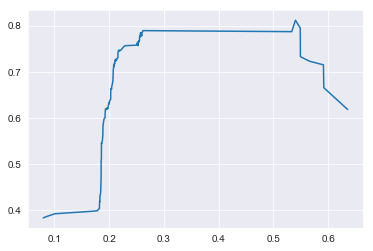

In [213]:
res = []
for yp in sorted(y_pred):
    y_pred_bin = (y_pred >= yp) * 1
    res.append(accuracy_score(data_gp.y, y_pred_bin))
plt.plot(sorted(y_pred), res)

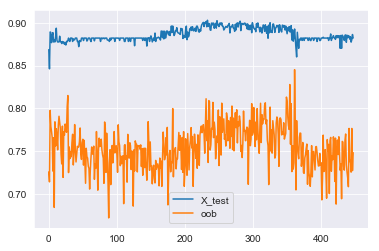

In [59]:
y_preds = [p.execute(data_gp.X_test.values) for p in gp2.run_details_['best_program']]
y_preds = [Outputs(y_pred) for y_pred in y_preds]
scores = [roc_auc_score(data_gp.y_test, y_pred) for y_pred in y_preds]

plt.plot(scores, label="X_test")
plt.plot(gp2.run_details_['best_oob_fitness'], label="oob")
plt.legend()

[<matplotlib.lines.Line2D at 0x1a34c5c0b8>]

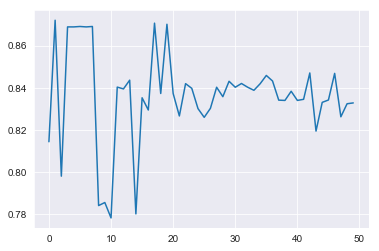

In [171]:
from gplearn.genetic import SymbolicTransformer

gp = SymbolicTransformer(generations=5, 
                         population_size=500,
                         hall_of_fame=100, 
                         n_components=10,
                         function_set=function_set, 
                         const_range=(-100, 100),
#                          metric='spearman',
                         tournament_size=3,
#                          parsimony_coefficient=0.0001,
                         parsimony_coefficient='auto', #0.0005,
                         max_samples=0.9, 
                         metric=roc_auc_fitness,
                         stopping_criteria=1.0,
                         verbose=1,
                         random_state=1, 
                         n_jobs=3)
gp.fit(data_gp.X_train, data_gp.y_train)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.05 0.49704558749609784        7 0.7999979201114822      0.751953125      8.37s
   1    10.79 0.5362179503417571        8 0.7999384615384615 0.8700088731144632      4.53s
   2    10.28 0.5577054359702336        5 0.8128349452166972 0.8484126984126985      2.77s
   3     9.89 0.5924578850981147       10 0.8238460041581745 0.7968181818181818      1.35s
   4     8.83 0.6195839897388035        5 0.8276143112255493 0.7812745869394178      0.00s


SymbolicTransformer(const_range=(-100, 100),
          function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan'],
          generations=5, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', max_samples=0.9,
          metric=<gplearn.fitness._Fitness object at 0x1a3a6f5c50>,
          n_components=10, n_jobs=3, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient='auto', population_size=500,
          random_state=1, stopping_criteria=1.0, tournament_size=3,
          verbose=1, warm_start=False)

In [186]:
# print(gp._programs[5][0])
gp2.run_details_

AttributeError: 'SymbolicRegressor' object has no attribute 'run_details_'

In [133]:
for program in gp:
    print(program)
    print(program.raw_fitness_)


add(X6, div(add(X6, X5), X3))
0.8335580500857059
add(X6, add(X6, div(X5, X3)))
0.8318745979690185
add(X6, add(X6, add(X6, add(X6, X5))))
0.8315615402787621
add(X6, add(X6, X5))
0.8313669481702267
add(X6, add(X6, add(X6, X5)))
0.8293902238314681
add(X6, div(X2, X3))
0.8285573323567709
add(add(X6, add(X6, X5)), log(X5))
0.8260780118499013
add(X6, log(add(X6, div(X5, X3))))
0.824051914580265
add(X6, log(add(X6, X5)))
0.8215879727507635
add(add(X6, div(X5, X3)), div(X5, X3))
0.8214852671575908


In [110]:
gp_features = pd.DataFrame(gp.transform(data_gp.X), index=data.X.index)
new_X = pd.concat([data_gp.X, gp_features], axis=1)
new_X.columns = list(map(str, new_X.columns))

gp_features = pd.DataFrame(gp.transform(data_gp.X_score), index=data.X_score.index)
new_X_score = pd.concat([data_gp.X_score, gp_features], axis=1)
new_X_score.columns = list(map(str, new_X_score.columns))

data_new = scil.Data(new_X, data_gp.y)
data_new.X_score = new_X_score

In [111]:
scif.df_summary(new_X)

,count,missing,percent,dtype,types,uniq,values,freq
Age,891,0,0.0000,float64,float,89,"-1.0, 0.42, 0.67, 0.75, 0.83, 0.92, 1.0, ...","'-1.0':177, '24.0':30, '22.0':27, '18.0':2..."
Cabin,891,0,0.0000,float64,float,9,"0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ...","'0.0':687, '3.0':59, '2.0':47, '5.0':33, '4..."
8,891,0,0.0000,float64,float,369,"0.2282049114186687, 1.1602829343291396, ...","'4.6498978251':41, '4.6678491154':32, '3...."
7,891,0,0.0000,float64,float,367,"2.16028293432914, 2.179463811342123, ...","'39.3905972401':41, '39.6453162458':32, '..."
6,891,0,0.0000,float64,float,226,"1.4142135623730951, 1.6817928305074292, ...","'1.8612097182':144, '1.4142135624':94, '1..."
5,891,0,0.0000,float64,float,19,"3.250091011337539, 4.250091011337539, ...","'16.7320508076':265, '13.7320508076':97, ..."
4,891,0,0.0000,float64,float,365,"0.16028293432913965, 0.17946381134212294, ...","'4.8655619875':41, '4.9017441359':32, '3...."
3,891,0,0.0000,float64,float,212,"0.0, 0.6931471805599453, ...","'1.0986122887':144, '0.0':94, '0.69314718..."
2,891,0,0.0000,float64,float,337,"1.0, 1.6411317373165586, ...","'1.0':81, '51.9336989056':40, '52.4974358..."
1,891,0,0.0000,float64,float,307,"0.0, 0.2682691245498961, ...","'0.0':94, '10.256234426':41, '10.31627742..."


In [118]:
import xgboost

model = xgboost.XGBClassifier()
scil.score_cv(data_new, model, scoring='accuracy')

CV for XGBClassifier ..


,mean,std
XGBClassifier,0.8115,0.0175


Can't plot with only a single or no samples


In [113]:
scil.fit(data_new, model)

fitting XGBClassifier ..


In [116]:
scil.get_top_features_by_permutation_importance(data_new, model, True, 'accuracy')

inverse_shuffle base_score: 0.5521 +/- 0.0035


0          98.6835
Cabin       7.8442
1           7.7345
2           6.5826
6           5.0466
Age         2.9073
8           2.0296
SibSp       1.4262
9           1.1519
3          -0.5485
Sex        -0.9874
Fare       -2.0296
5          -3.2913
7          -3.7850
Embarked   -4.7175
Parch      -4.8272
4          -5.5403
Pclass     -7.6796
dtype: float64

In [32]:
ds = data_new
path = 'processed_min_gp'
!mkdir -p $path
ds.X.to_msgpack(f'{path}/X.msgpack')
ds.y.to_msgpack(f'{path}/y.msgpack')
ds.X_score.to_msgpack(f'{path}/X_score.msgpack')

# from sklearn.externals import joblib
# joblib.dump(y_tr, f'{path}/y_tr.joblib')


## Quick Test

In [26]:
import sklearn.utils
from sklearn.linear_model import *


In [29]:
import xgboost
from sklearn.svm import SVC, LinearSVC, NuSVC

# model = ElasticNetCV(l1_ratio=0.5)
model = xgboost.XGBClassifier()
# model = SVC(kernel="linear", C=0.025, probability=True)

# sci.metric_global = roc_auc_score
scil.scoring_global = 'accuracy'

path = 'processed_min'

data = scil.load_data(path)
cv_scores = scil.score_cv(data, model, scoring=scil.scoring_global, verbose=2, cv=10)

(891, 8) (891,)
CV for XGBClassifier ..


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  10 out of  10 | elapsed:    0.4s finished


,mean,std
XGBClassifier,0.8160,0.0125


Can't plot with only a single or no samples
